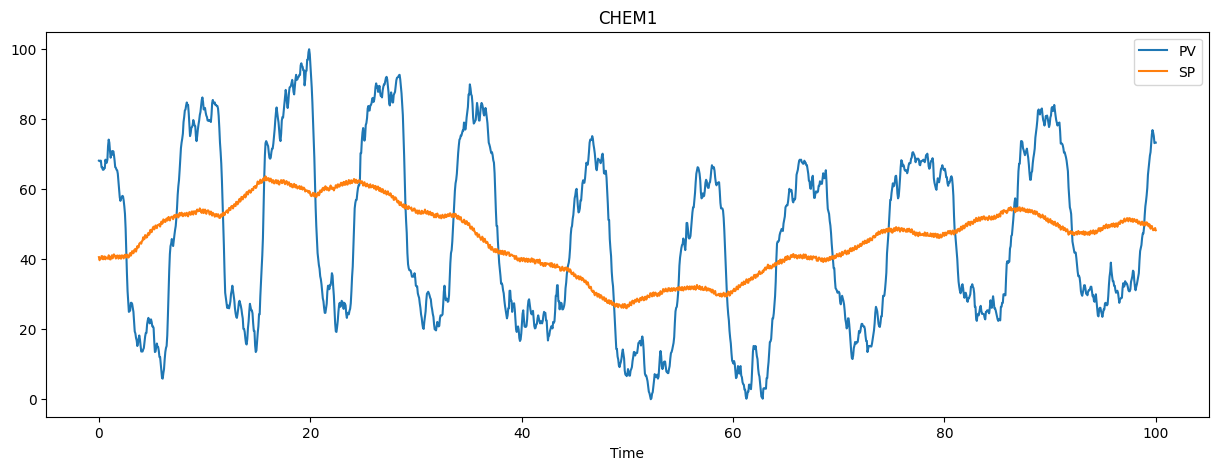

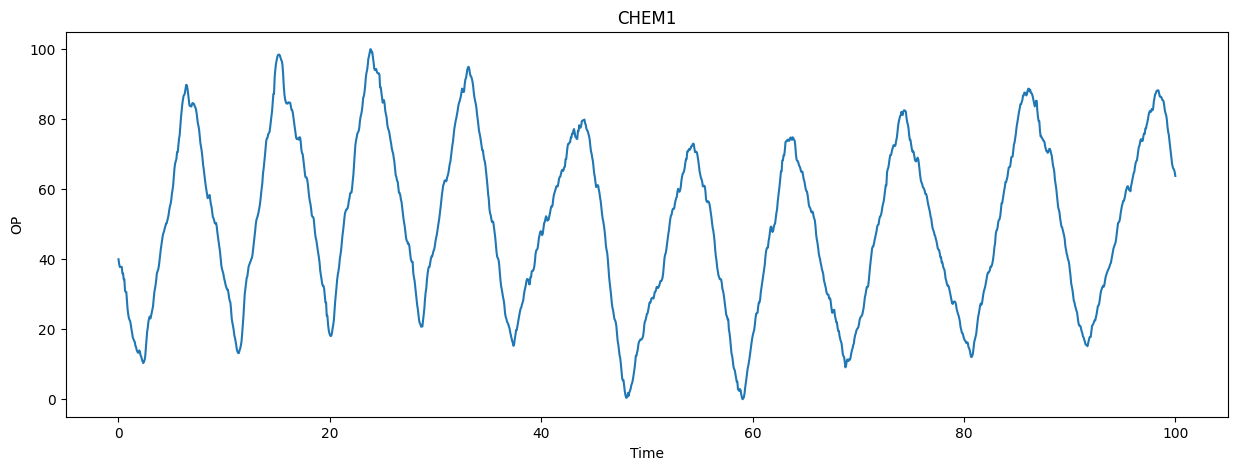

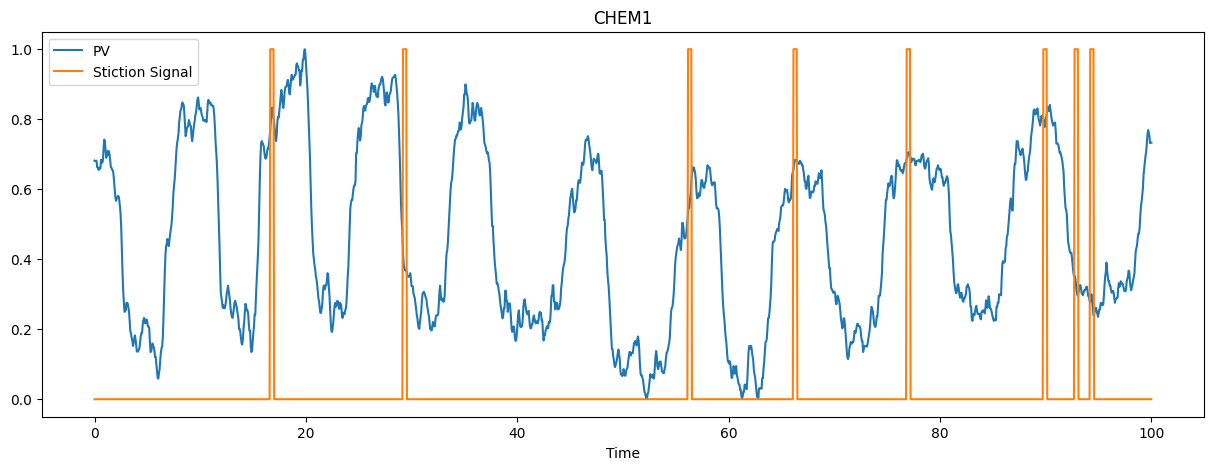

Given control valve has sticiton
Stiction index = 2.973977695167286
Estimated degree of stiction = 0.06369800000000225


In [54]:
# Practical Linear Regression-Based Method for Detection and Quantification of Stiction in Control Valves, Industrial & Engineering Chemistry Research, Vol. 61, pp. 502-514, 2021.
# Pyhton code for stiction detection in CHEM1 of International Stiction Database (ISDB)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import linear_model
import math

xlsx = pd.ExcelFile("/content/data.xlsx")
data = pd.read_excel(xlsx, 'CHEM1',header=0)

data = np.array(data)
OP = data[:,0]
PV = data[:,1]
SP = data[:,2]
t = data[:,3]

OP = OP.reshape(1,data.shape[0])
PV = PV.reshape(1,data.shape[0])
SP = SP.reshape(1,data.shape[0])
t = t.reshape(1,data.shape[0])

#print(OP.shape)
#print(PV.shape)
#print(SP.shape)
#print(t.shape)

#print(OP[0,:])
#print(PV[0,:])
#print(SP[0,:])
#print(t[0,:])

PV_low=np.min(PV);
PV_high=np.max(PV);

OP_low=np.min(OP);
OP_high=np.max(OP);

PV=((PV-PV_low)/(PV_high-PV_low))*100;
OP=((OP-OP_low)/(OP_high-OP_low))*100;
SP=((SP-PV_low)/(PV_high-PV_low))*100;

#print(OP.shape)
#print(PV.shape)
#print(SP.shape)
#print(t.shape)

t_low=np.min(t);
t_high=np.max(t);
t=((t-t_low)/(t_high-t_low))*100;

plt.figure(figsize=(15,5))
plt.plot(t.T,PV.T, label='PV')
plt.plot(t.T,SP.T, label='SP')
plt.xlabel("Time")
plt.legend()
# displaying the title
plt.title("CHEM1")
plt.show()

plt.figure(figsize=(15,5))
plt.plot(t.T,OP.T)
plt.xlabel("Time")
plt.ylabel('OP')
# displaying the title
plt.title("CHEM1")
plt.show()

# parameters of the method
mws = 6  # size of moving window
thrsld = 15   # threshold

slopePV=[]
slopeOP=[]

#print(PV.shape[1])

a1 = 0
for i in range(1,math.floor((PV.shape[1])/mws)):  #math.floor((PV.shape[1])/mws)
  pvdata = PV[:,a1:i*mws]
  opdata = OP[:,a1:i*mws]
  xdata = t[:,a1:i*mws]

  #print(pvdata)
  #print(opdata)
  #print(xdata)

  model1 = linear_model.LinearRegression()
  model1.fit(xdata.T,pvdata.T)

  model2 = linear_model.LinearRegression()
  model2.fit(xdata.T,opdata.T)

  #print(model1.coef_)
  #print(model2.coef_)

  slopePV.append(abs(model1.coef_))
  slopeOP.append(abs(model2.coef_))

  a1 = i*mws
# end of for loop

slopePV = np.array(slopePV)
slopeOP = np.array(slopeOP)

slopeOP = slopeOP.reshape(len(slopeOP),1)
slopePV = slopePV.reshape(len(slopePV),1)

#print(len(slopeOP))
#print(slopePV.shape)

mratio = np.divide(slopeOP,slopePV)
#mratio = mratio.reshape()
#print((mratio[0,:]))

sign_stic = np.zeros((1,len(mratio)))
stiction = np.zeros((1,PV.shape[1]))

#stiction[:,6:2*6] = np.ones((1,mws))
#print(stiction[:,6:2*6])
#print(np.ones((1,mws)))

a2=0
for i in range(1,len(mratio)):
  if i-1==0:
    if mratio[i-1,:] > thrsld:
      sign_stic [:,i-1] = 1
      stiction[:,a2:i*mws] = np.ones((1,mws))
  else:
    if mratio[i,:] > thrsld:
      sign_stic[:,i] = 1
      stiction[:,a2:i*mws] = np.ones((1,mws))

  a2 = i*mws

stic_index = np.mean(sign_stic)*100

plt.figure(figsize=(15,5))
plt.plot(t.T,(PV/100).T, label='PV')
plt.plot(t.T,stiction.T, label='Stiction Signal')
plt.xlabel("Time")
plt.legend()
# displaying the title
plt.title("CHEM1")
plt.show()

# stiction qunatification
if stic_index==0:
  print('Given control valve has no stiction')
else:
  OP=(OP/100)*(OP_high-OP_low)+OP_low;
  OP_org = OP
  stic_bands = []
  ab = 0
  d = []

#aa = OP_org[:,0:mws-1]
#print(aa)
#bb=list(aa)
#print(bb[0][-1])
#print(aa[:,-1])

#sign_stic[:,0] = 1
#sign_stic[:,1] = 1
#print(sign_stic)
  for i in range(0,sign_stic.shape[1]):
    if i==0:
      if sign_stic[:,i] > 0:
        k = 1
        d.extend(OP_org[:,0:mws])
      else:
        k = 0
        d = []
    elif i > 0:
      if k==1 and sign_stic[:,i]>0:
        k = 1
        d.extend(OP_org[:,(i*mws):(i+1)*mws])  #
      elif k==1 and sign_stic[:,i]==0:
        k=0
        if len(d)==1:
          stic_bands.append(abs(d[0][0] - d[0][-1]))
        elif len(d)>1:
          stic_bands.append(abs(d[0][0] - d[len(d)-1][-1]))

        ab = ab+1
        d = []
      elif k==0 and sign_stic[:,i]==0:
        k = 0
        d = []
      elif k==0 and sign_stic[:,i]>0:
        k = 1
        d.extend(OP_org[:,(i*mws):(i+1)*mws])

  print('Given control valve has sticiton')
  stic_bands = np.array(stic_bands)
  estimated_stiction = np.max(stic_bands)
  print('Stiction index =',stic_index)
  print('Estimated degree of stiction =',estimated_stiction)

# end of sticiton quantificaiton

















